In [1]:
import sys; print('Python %s on %s' % (sys.version, sys.platform))
sys.path.extend(['C:\\Users\\user\\PycharmProjects\\Open_Close_GNN'])

Python 3.7.16 (default, Jan 17 2023, 16:06:28) [MSC v.1916 64 bit (AMD64)] on win32


In [2]:
from model.dataset import oldOpenCloseDataset
from model.gnn_model import GCN, GATv2
import os
from model.utils import train, device, train_epoch, eval_epoch, cross_val
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler
from torch_geometric.loader import DataLoader

from seaborn import heatmap

In [5]:
import torch
from torch_geometric.data import Dataset, Data
from torch_geometric.utils import dense_to_sparse
from scipy.sparse import coo_matrix
import numpy as np
import os
from scipy.io import loadmat
import pandas as pd
import numpy.ma as ma


class OpenCloseDataset(Dataset):
    def __init__(self, datafolder, reload=False, test=False, transform=None, pre_transform=None, k_degree=10):
        self.reload = reload
        self.test = test
        self.datafolder = datafolder
        self.close = np.load(f'{datafolder}/raw/close_conc.npy') #resultsROI_Condition001.mat')['Z']
        self.open  = np.load(f'{datafolder}/raw/close_conc.npy') #resultsROI_Condition002.mat')['Z']
        self.cortical_division = np.load('../data/tfidf_vecs.npy')
        self.cortical_division = torch.from_numpy(self.cortical_division).float()

        self.edge_attr = None
        self.k_degree = k_degree
        #self.dl = np.array([256, 257, 258, 259]) # [52, 256, 53, 257, 54, 258, 55, 259]

        super().__init__(root=datafolder, transform=transform, pre_transform=pre_transform)

    @property
    def raw_file_names(self):
        return ['resultsROI_Condition001.mat', 'resultsROI_Condition002.mat']
    
    @property
    def processed_file_names(self):
        if self.reload:
            return [f'_data_{i}.pt' for i in range(84*2)]
        else:
            return [f'data_{i}.pt' for i in range(84*2)]
        
    def len(self):
        return 84 + 84
    
    def download(self):
        print('yo')
    
    def process(self):

        for index in range(84):
            _ = self._load_and_save(index, 'open')

        for index in range(84):
            _ = self._load_and_save(index, 'close')

    def _load_and_save(self, index, state):

        if state == 'open':
            #matr = self.open[:, :, index]
        elif state == 'close':
            #matr = self.close[:, :, index]

        #np.fill_diagonal(matr, 0)
        
        #matr = np.delete(matr, self.dl, 0)
        #matr = np.delete(matr, self.dl, 1)
        #matr = np.tanh(matr)

        x = torch.from_numpy(matr).float()

        if self.k_degree is not None:
            adj = self.compute_KNN_graph(matr, k_degree=self.k_degree)
            adj = torch.from_numpy(adj).float()
            edge_index, edge_attr = dense_to_sparse(adj)
            self.edge_attr = edge_attr
        else:
            edge_index = self._adjacency_threshold(x)

        label = torch.tensor(0 if state == 'close' else 1).long()
        data = Data(x=x, edge_index=edge_index, y=label)
        #data = Data(x=self.cortical_division, edge_index=edge_index, edge_attr=self.edge_attr, y=label)

        index = index + 84 if state == 'close' else index
        if self.test:
            torch.save(data,
                       os.path.join(self.processed_dir, 'test',
                                    f'data_{index}.pt'))
        else:
            torch.save(data,
                       os.path.join(self.processed_dir,
                                    f'data_{index}.pt'))
        return data
    
    def compute_KNN_graph(self, matrix, k_degree):
        """ Calculate the adjacency matrix from the connectivity matrix."""

        matrix = np.abs(matrix)
        idx = np.argsort(-matrix)[:, 0:k_degree]
        matrix.sort()
        matrix = matrix[:, ::-1]
        matrix = matrix[:, 0:k_degree]

        A = self._adjacency(matrix, idx).astype(np.float32)

        return A

    def _adjacency(self, dist, idx):

        m, k = dist.shape
        assert m, k == idx.shape
        assert dist.min() >= 0

        # Weight matrix.
        I = np.arange(0, m).repeat(k)
        J = idx.reshape(m * k)
        V = dist.reshape(m * k)
        W = coo_matrix((V, (I, J)), shape=(m, m))

        # No self-connections.
        W.setdiag(0)

        # Non-directed graph.
        bigger = W.T > W
        W = W - W.multiply(bigger) + W.T.multiply(bigger)

        return W.todense()

    def _adjacency_threshold(self, matr, threshold=0.5):
        # todo optimize ???
        # todo переделать порог
        idx = []
        for i in range(len(matr)):
            for j in range(len(matr)):
                if abs(matr[i, j]) > threshold:
                    idx.append((i, j))

        return torch.tensor(idx).long().t().contiguous()

    def get(self, idx):
        """ - Equivalent to __getitem__ in pytorch
            - Is not needed for PyG's InMemoryDataset
        """
        if self.test:
            data = torch.load(os.path.join(self.processed_dir,
                                           f'data_test_{idx}.pt'))
        else:
            data = torch.load(os.path.join(self.processed_dir,
                                           f'data_{idx}.pt'))
        return data

IndentationError: expected an indented block (1063251902.py, line 57)

In [3]:
import torch
from torch_geometric.data import Dataset, Data
from torch_geometric.utils import dense_to_sparse
from scipy.sparse import coo_matrix
import numpy as np
import os
from scipy.io import loadmat
import pandas as pd
import numpy.ma as ma

class oldOpenCloseDataset(Dataset):

    def __init__(self, datafolder, reload=False, test=False, transform=None, pre_transform=None, k_degree=10):

        self.reload = reload
        self.test = test
        self.datafolder = datafolder
        self.close = np.load(f'{datafolder}/raw/close_conc.npy') 
        self.open  = np.load(f'{datafolder}/raw/open_conc.npy')
        self.edge_attr = None
        self.k_degree = k_degree

        super().__init__(root=datafolder, transform=transform, pre_transform=pre_transform)

    @property
    def raw_file_names(self):
        return ['close_conc.npy', 'open_conc.npy']

    @property
    def processed_file_names(self):
        if self.reload:
            return [f'_data_{i}.pt' for i in range(3528*2)]
        else:
            return [f'data_{i}.pt' for i in range(3528*2)]

    def download(self):
        print('yo')

    def process(self):

        for index, matr in enumerate(self.open):
            _ = self._load_and_save(matr, index, 'open')

        for index, matr in enumerate(self.close):
            _ = self._load_and_save(matr, index, 'close')

    def _load_and_save(self, matr, index, state):

        x = torch.from_numpy(matr).float()

        if self.k_degree is not None:
            adj = self.compute_KNN_graph(matr, k_degree=self.k_degree)
            adj = torch.from_numpy(adj).float()
            edge_index, edge_attr = dense_to_sparse(adj)
            self.edge_attr = edge_attr
        else:
            edge_index = self._adjacency_threshold(x)

        label = torch.tensor(0 if state == 'close' else 1).long()

        data = Data(x=x, edge_index=edge_index, y=label)

        index = index + 3528 if state == 'close' else index
        if self.test:
            torch.save(data,
                       os.path.join(self.processed_dir, 'test',
                                    f'data_{index}.pt'))
        else:
            torch.save(data,
                       os.path.join(self.processed_dir,
                                    f'data_{index}.pt'))
        return data

    def compute_KNN_graph(self, matrix, k_degree):
        """ Calculate the adjacency matrix from the connectivity matrix."""

        matrix = np.abs(matrix)
        idx = np.argsort(-matrix)[:, 0:k_degree]
        matrix.sort()
        matrix = matrix[:, ::-1]
        matrix = matrix[:, 0:k_degree]

        A = self._adjacency(matrix, idx).astype(np.float32)

        return A

    def _adjacency(self, dist, idx):

        m, k = dist.shape
        assert m, k == idx.shape
        assert dist.min() >= 0

        # Weight matrix.
        I = np.arange(0, m).repeat(k)
        J = idx.reshape(m * k)
        V = dist.reshape(m * k)
        W = coo_matrix((V, (I, J)), shape=(m, m))

        # No self-connections.
        W.setdiag(0)

        # Non-directed graph.
        bigger = W.T > W
        W = W - W.multiply(bigger) + W.T.multiply(bigger)

        return W.todense()

    def _adjacency_threshold(self, matr, threshold=0.5):
        # todo optimize ???
        idx = []
        for i in range(len(matr)):
            for j in range(len(matr)):
                if abs(matr[i, j]) > threshold:
                    idx.append((i, j))

        return torch.tensor(idx).long().t().contiguous()

    def len(self):
        return 3528*2  # len(self.files)

    def get(self, idx):
        """ - Equivalent to __getitem__ in pytorch
            - Is not needed for PyG's InMemoryDataset
        """
        if self.test:
            data = torch.load(os.path.join(self.processed_dir,
                                           f'data_test_{idx}.pt'))
        else:
            data = torch.load(os.path.join(self.processed_dir,
                                           f'data_{idx}.pt'))
        return data
    

In [4]:
full_dataset = oldOpenCloseDataset(datafolder='../data/new', reload=True, k_degree=10).shuffle()
len(os.listdir('../data/new/processed'))

Processing...
Done!


7058

In [5]:
len(full_dataset)

7056

In [7]:
train_size = int(0.8 * len(full_dataset))
train_dataset, val_dataset = full_dataset[:train_size], full_dataset[train_size:]
val_dataset, test_dataset = val_dataset[:-150], val_dataset[-150:]

# len train - 134
# val - 19
# test - 15

In [8]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8)

## GCN

In [9]:
import torch.nn as nn
from torch_geometric.nn import global_mean_pool, GCNConv, GATv2Conv, BatchNorm

class GCN(nn.Module):
    def __init__(self, num_features, channels, dropout=.3):
        super().__init__()
        self.conv1 = GCNConv(int(num_features), channels[0])
        self.bn1 = BatchNorm(channels[0])
        self.conv2 = GCNConv(channels[0], channels[1])
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        self.lin1 = nn.Linear(channels[1], 2)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        batch = data.batch
        x = self.relu(self.conv1(x, edge_index, edge_attr))
        x = self.bn1(x)
        x = self.relu(self.conv2(x, edge_index, edge_attr))
        x = self.dropout(x)
        x = global_mean_pool(x, batch)
        x = self.lin1(x)
        return x

In [20]:
torch.cuda.empty_cache()

In [10]:
model = GCN(full_dataset.num_features, channels=[256, 8], dropout=0.1).to(device())
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss = torch.nn.CrossEntropyLoss()
epochs = 10
scheduler = lr_scheduler.StepLR(optimizer, step_size=epochs//3, gamma=0.1, last_epoch=-1, verbose=True)
sum(p.numel() for p in model.parameters())

Adjusting learning rate of group 0 to 1.0000e-03.


111898

In [11]:
history = train(model, epochs, train_loader, val_loader, loss, optimizer, scheduler=scheduler)

  0%|          | 0/10 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 001, Train Loss: 0.0001, Test Loss 0.0001, Train Acc: 1.0000, Test Acc: 1.0000
Test precision: 1.0000, Test recall: 1.0000
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 002, Train Loss: 0.0001, Test Loss 0.0001, Train Acc: 1.0000, Test Acc: 1.0000
Test precision: 1.0000, Test recall: 1.0000


KeyboardInterrupt: 

In [23]:
train_loss, val_loss, train_acc, test_acc = zip(*history)
plt.plot(train_loss, label='train loss')
plt.plot(val_loss, label='val loss')
plt.legend();

NameError: name 'history' is not defined

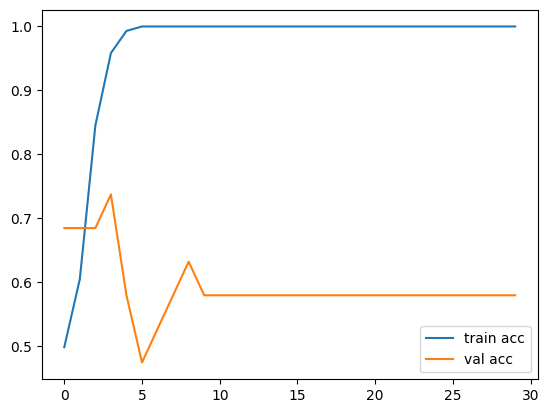

In [28]:
plt.plot(train_acc, label='train acc')
plt.plot(test_acc, label='val acc')
plt.legend();

In [29]:
np.mean(test_acc)

0.59122795

In [12]:
test_loader = DataLoader(test_dataset)
eval_epoch(test_loader, model, loss)
# loss, acc, precision, recall

(5.844453369964716e-05, 1.0, 0.54, 0.54)

## GAT

In [64]:
model = GATv2(full_dataset.num_features, 128, 8, dropout=0.1).to(device())
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
loss = torch.nn.CrossEntropyLoss()
epochs = 50
scheduler = lr_scheduler.StepLR(optimizer, step_size=epochs//3, gamma=0.1, last_epoch=-1, verbose=False)
sum(p.numel() for p in model.parameters())

221746

In [65]:
history = train(model, epochs, train_loader, val_loader, loss, optimizer, scheduler=None)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 001, Train Loss: 0.0478, Test Loss 0.0392, Train Acc: 0.5208, Test Acc: 0.4737
Test precision: 0.4737, Test recall: 1.0000
Epoch: 002, Train Loss: 0.0460, Test Loss 0.0392, Train Acc: 0.5324, Test Acc: 0.4737
Test precision: 0.4737, Test recall: 1.0000
Epoch: 003, Train Loss: 0.0432, Test Loss 0.0391, Train Acc: 0.5833, Test Acc: 0.4737
Test precision: 0.4737, Test recall: 1.0000
Epoch: 004, Train Loss: 0.0391, Test Loss 0.0392, Train Acc: 0.6852, Test Acc: 0.4737
Test precision: 0.4667, Test recall: 0.7778
Epoch: 005, Train Loss: 0.0340, Test Loss 0.0392, Train Acc: 0.7731, Test Acc: 0.4211
Test precision: 0.4286, Test recall: 0.6667
Epoch: 006, Train Loss: 0.0297, Test Loss 0.0387, Train Acc: 0.8194, Test Acc: 0.4211
Test precision: 0.4286, Test recall: 0.6667
Epoch: 007, Train Loss: 0.0270, Test Loss 0.0381, Train Acc: 0.8403, Test Acc: 0.4211
Test precision: 0.4286, Test recall: 0.6667
Epoch: 008, Train Loss: 0.0248, Test Loss 0.0377, Train Acc: 0.8565, Test Acc: 0.4737
Test

In [66]:
eval_epoch(test_loader, model, loss)
# loss, acc, precision, recall

(0.8265951127861626, 0.6666667, 0.26666668, 0.26666668)

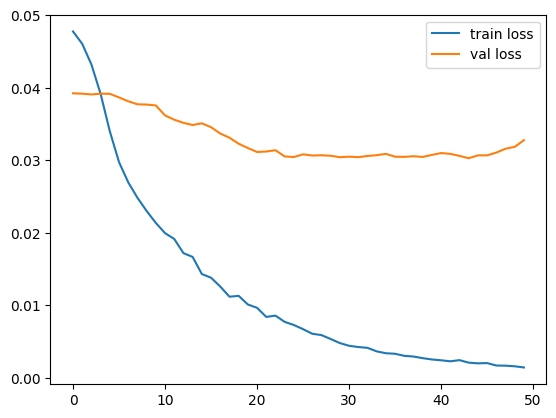

In [67]:
train_loss, val_loss, train_acc, test_acc = zip(*history)
plt.plot(train_loss, label='train loss')
plt.plot(val_loss, label='val loss')
plt.legend();

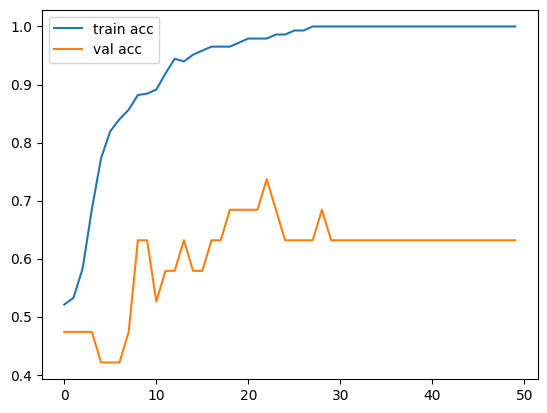

In [68]:
plt.plot(train_acc, label='train acc')
plt.plot(test_acc, label='val acc')
plt.legend();

In [69]:
np.mean(test_acc)

0.6052631

In [22]:
torch.save(model.state_dict(), '../weights/gat_2heads_128_8_knn10_crossval.pt')

## Cross-validation

In [71]:
# GCN

from sklearn.model_selection import StratifiedKFold
from tqdm.notebook import tqdm

skf = StratifiedKFold(n_splits=6, shuffle=True)
eval_metrics = np.zeros((skf.n_splits, 3))
crossval_dataset = train_dataset #+ val_dataset

labels = [crossval_dataset[i].y for i in range(len(crossval_dataset))]


for n_fold, (train_idx, test_idx) in tqdm(enumerate(skf.split(labels, labels))):
    model = GCN(crossval_dataset.num_features, channels=[256, 32], dropout=0.3).to(device())
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.CrossEntropyLoss()
    scheduler = lr_scheduler.StepLR(optimizer, step_size=30//3, gamma=0.1, last_epoch=-1, verbose=False)

    train_loader_ = DataLoader(crossval_dataset[list(train_idx)], batch_size=8, shuffle=True)
    test_loader_ = DataLoader(crossval_dataset[list(test_idx)], batch_size=8, shuffle=True)
    min_v_loss = np.inf
    print(n_fold)
    pr, rc, acc = [], [], []
    for epoch in range(20):
        train_epoch(train_loader_, model, criterion, optimizer)
        train_loss, train_acc, _, _ = eval_epoch(train_loader_, model, criterion)
        val_loss, test_acc, _, _ = eval_epoch(test_loader_, model, criterion)
        #scheduler.step()
        print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Test Loss {val_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
        #print(f'Train Prec: {train_pr:.3f}, Train Rec: {train_rc:.3f}, Test Prec: {val_pr:.3f}, Test Rec: {val_rc:.3f}')
        #rc.append(val_rc)
        #pr.append(val_pr)
        acc.append(test_acc)
        if min_v_loss > val_loss:
            min_v_loss = val_loss
            best_test_acc = test_acc

    eval_metrics[n_fold, 0] = best_test_acc
    eval_metrics[n_fold, 1] = np.mean(acc)
    eval_metrics[n_fold, 2] = np.std(acc)
### eval_metrics[n_fold, 3] =

0it [00:00, ?it/s]

0
Epoch: 000, Train Loss: 0.0806, Test Loss 0.0879, Train Acc: 0.8482, Test Acc: 0.6964
Epoch: 001, Train Loss: 0.0637, Test Loss 0.0830, Train Acc: 0.9643, Test Acc: 0.5714
Epoch: 002, Train Loss: 0.0406, Test Loss 0.0759, Train Acc: 0.9809, Test Acc: 0.6488
Epoch: 003, Train Loss: 0.0219, Test Loss 0.0730, Train Acc: 1.0000, Test Acc: 0.6190
Epoch: 004, Train Loss: 0.0113, Test Loss 0.0671, Train Acc: 1.0000, Test Acc: 0.6548
Epoch: 005, Train Loss: 0.0062, Test Loss 0.0630, Train Acc: 1.0000, Test Acc: 0.7024
Epoch: 006, Train Loss: 0.0036, Test Loss 0.0708, Train Acc: 1.0000, Test Acc: 0.6905
Epoch: 007, Train Loss: 0.0022, Test Loss 0.0642, Train Acc: 1.0000, Test Acc: 0.6964
Epoch: 008, Train Loss: 0.0014, Test Loss 0.0653, Train Acc: 1.0000, Test Acc: 0.6964
Epoch: 009, Train Loss: 0.0010, Test Loss 0.0715, Train Acc: 1.0000, Test Acc: 0.6964
Epoch: 010, Train Loss: 0.0008, Test Loss 0.0689, Train Acc: 1.0000, Test Acc: 0.7440
Epoch: 011, Train Loss: 0.0006, Test Loss 0.0714, Tr

In [72]:
eval_epoch(test_loader, model, loss)

(0.7578488029335858, 0.6666667, 0.4, 0.4)

In [36]:
eval_metrics
# acc during minimal loss, mean acc, std

array([[0.64285713, 0.61398804, 0.06108881],
       [0.91666669, 0.80565482, 0.14652142],
       [0.72222227, 0.69999993, 0.07275445],
       [0.625     , 0.64027774, 0.06068347],
       [0.7638889 , 0.72847223, 0.09249154],
       [0.6388889 , 0.58541662, 0.06074304]])

In [73]:
# mean acc across all folds 
np.mean(eval_metrics[:, 1]), np.std(eval_metrics[:, 1])

(0.685482790072759, 0.05847524153388064)

In [38]:
# GAT

from sklearn.model_selection import StratifiedKFold
from tqdm.notebook import tqdm

skf = StratifiedKFold(n_splits=6, shuffle=True)
eval_metrics = np.zeros((skf.n_splits, 3))

labels = [train_dataset[i].y for i in range(len(train_dataset))]


for n_fold, (train_idx, test_idx) in tqdm(enumerate(skf.split(labels, labels))):
    model = GATv2(train_dataset.num_features, 128, 8).to(device())
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.CrossEntropyLoss()
    scheduler = lr_scheduler.StepLR(optimizer, step_size=30//3, gamma=0.1, last_epoch=-1, verbose=False)

    train_loader_ = DataLoader(train_dataset[list(train_idx)], batch_size=8, shuffle=True)
    test_loader_ = DataLoader(train_dataset[list(test_idx)], batch_size=8, shuffle=True)
    min_v_loss = np.inf
    print(n_fold)
    pr, rc, acc = [], [], []
    for epoch in range(20):
        train_epoch(train_loader_, model, criterion, optimizer)
        train_loss, train_acc, _, _ = eval_epoch(train_loader_, model, criterion)
        val_loss, test_acc, _, _ = eval_epoch(test_loader_, model, criterion)
        #scheduler.step()
        print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Test Loss {val_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
        #print(f'Train Prec: {train_pr:.3f}, Train Rec: {train_rc:.3f}, Test Prec: {val_pr:.3f}, Test Rec: {val_rc:.3f}')
        #rc.append(val_rc)
        #pr.append(val_pr)
        acc.append(test_acc)
        if min_v_loss > val_loss:
            min_v_loss = val_loss
            best_test_acc = test_acc

    eval_metrics[n_fold, 0] = best_test_acc
    eval_metrics[n_fold, 1] = np.mean(acc)
    eval_metrics[n_fold, 2] = np.std(acc)
### eval_metrics[n_fold, 3] =

0it [00:00, ?it/s]

0
Epoch: 000, Train Loss: 0.0821, Test Loss 0.0891, Train Acc: 0.7092, Test Acc: 0.6548
Epoch: 001, Train Loss: 0.0528, Test Loss 0.0777, Train Acc: 0.9094, Test Acc: 0.7024
Epoch: 002, Train Loss: 0.0227, Test Loss 0.0716, Train Acc: 0.9643, Test Acc: 0.7857
Epoch: 003, Train Loss: 0.0094, Test Loss 0.0710, Train Acc: 0.9911, Test Acc: 0.6488
Epoch: 004, Train Loss: 0.0043, Test Loss 0.0774, Train Acc: 1.0000, Test Acc: 0.6964
Epoch: 005, Train Loss: 0.0020, Test Loss 0.0774, Train Acc: 1.0000, Test Acc: 0.6905
Epoch: 006, Train Loss: 0.0011, Test Loss 0.0833, Train Acc: 1.0000, Test Acc: 0.6964
Epoch: 007, Train Loss: 0.0008, Test Loss 0.0872, Train Acc: 1.0000, Test Acc: 0.7500
Epoch: 008, Train Loss: 0.0005, Test Loss 0.0853, Train Acc: 1.0000, Test Acc: 0.7381
Epoch: 009, Train Loss: 0.0004, Test Loss 0.0889, Train Acc: 1.0000, Test Acc: 0.6964
Epoch: 010, Train Loss: 0.0003, Test Loss 0.0902, Train Acc: 1.0000, Test Acc: 0.7321
Epoch: 011, Train Loss: 0.0002, Test Loss 0.0930, Tr

In [39]:
eval_metrics

array([[0.64880949, 0.72738093, 0.03720121],
       [0.64880949, 0.57589281, 0.05564362],
       [0.8611111 , 0.7520833 , 0.0579809 ],
       [0.77777773, 0.75972229, 0.04437928],
       [0.65277773, 0.72222221, 0.04143455],
       [0.65277773, 0.62499994, 0.04479031]])

In [40]:
np.mean(eval_metrics[:, 1]), np.std(eval_metrics[:, 1])

(0.6937169134616852, 0.06869462128180329)

In [41]:
eval_epoch(test_loader, model, loss)

(0.32423661667514003, 0.8, 0.46666667, 0.46666667)

## Explainability

In [ ]:
from captum.attr import Saliency, IntegratedGradients

def model_forward(edge_mask, data):
    batch = torch.zeros(data.x.shape[0], dtype=int).to(device())
    out = model(data) # .x, data.edge_index, batch, edge_mask
    return out


def explain(method, data, target=0):
    input_mask = torch.ones(data.edge_index.shape[1]).requires_grad_(True).to(device)
    if method == 'ig':
        ig = IntegratedGradients(model_forward)
        mask = ig.attribute(input_mask, target=target,
                            additional_forward_args=(data,),
                            internal_batch_size=data.edge_index.shape[1])
    elif method == 'saliency':
        saliency = Saliency(model_forward)
        mask = saliency.attribute(input_mask, target=target,
                                  additional_forward_args=(data,))
    else:
        raise Exception('Unknown explanation method')

    edge_mask = np.abs(mask.cpu().detach().numpy())
    if edge_mask.max() > 0:  # avoid division by zero
        edge_mask = edge_mask / edge_mask.max()
    return edge_mask